# 3. Data preparation

In [1]:
# Load the dataset
import pandas as pd
import numpy as np
path = " " # insert path to the data
filename = "caesarian.csv"
df = pd.read_csv(path+filename, header = None, skiprows = 17,
                 names = ['Age','Delivery number','Delivery time','Blood pressure', 'Heart problem', 'Caesarian'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 6 columns):
Age                80 non-null int64
Delivery number    80 non-null int64
Delivery time      80 non-null int64
Blood pressure     80 non-null int64
Heart problem      80 non-null int64
Caesarian          80 non-null int64
dtypes: int64(6)
memory usage: 3.8 KB


In [2]:
# Define the variables
X = df.drop('Caesarian', axis =1)
y = df['Caesarian']

In [3]:
# Take care of categorical data using dummy variables
columns_to_encode = ['Delivery time', 'Blood pressure', 'Heart problem']
encoded_columns = pd.get_dummies(df[columns_to_encode],columns=columns_to_encode,drop_first=True)
encoded_columns.head()

,Delivery time_1,Delivery time_2,Blood pressure_1,Blood pressure_2,Heart problem_1
0,0,0,0,1,0
1,0,0,1,0,0
2,1,0,1,0,0
3,0,0,0,1,0
4,0,0,1,0,0


In [4]:
encoded_columns = encoded_columns.values

In [5]:
# Scale the numerical features
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
columns_to_scale = ['Age','Delivery number']
scaled_columns = sc_X.fit_transform(df[columns_to_scale])

//anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
X = np.concatenate([encoded_columns, scaled_columns], axis = 1)

## Training set and test set

In [7]:
# Splitting the dataset into the Training set and the Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [8]:
y_test.value_counts()

1    12
0    12
Name: Caesarian, dtype: int64

# 4. Spot checking algorithms
In order to quicky identify if prediction is feasible on the dataset, and identify what model would work best, we'll spot check different types of algorithms.
This approach is recommended on the __[Machine Learning Mastery website](https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/)__ (and especially __[here for reusable framework](https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/)__).

In [9]:
# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(solver = 'lbfgs')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(kernel = 'linear', gamma = 'auto')))
models.append(('kSVM', SVC(kernel = 'rbf', gamma = 'auto')))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators = 10)))
models.append(('GBM', GradientBoostingClassifier()))

In [11]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.626667 (0.143604)
LDA: 0.643333 (0.156383)
KNN: 0.593333 (0.159722)
SVM: 0.640000 (0.167862)
kSVM: 0.646667 (0.191601)
NB: 0.696667 (0.132035)
CART: 0.500000 (0.161933)
RF: 0.553333 (0.133500)
GBM: 0.500000 (0.122927)


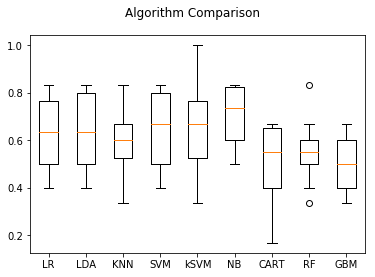

In [12]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Best results are obtained using Naive Bayes and Support Vector Machine algorithms. We'll try to fine tune these 2 models to improve their performances and select the best final model.
# 5. Modeling

In [13]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV

## Naive Bayes
We'll grid search the parameters to fine tune the Naive Bayes model.

In [14]:
parameters = {'var_smoothing' : [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
              #'priors' : [None]
             } 
classifier = GaussianNB()
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

//anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
print(best_accuracy)
print(best_parameters)

0.642857142857
{'var_smoothing': 1e-09}


## Support Vector Machine

In [16]:
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma' : [0.5, 0.1, 0.01, 0.001, 0.0001]},
                {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree' : [0, 1, 2, 3, 4, 5, 6]}
             ]

classifier =SVC()
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [17]:
print(best_accuracy)
print(best_parameters)

0.678571428571
{'gamma': 0.1, 'C': 1, 'kernel': 'rbf'}


Fine tuned kernel SVM performs better than Naive Bayes algorithm on this dataset. We select the kernel SVM model and assess if its performance can be further improved.

In [18]:
parameters ={'C': [0.9, 1, 1.1], 'kernel': ['rbf'], 'gamma' : [0.09, 0.1, 0.11]}

classifier =SVC()
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy)
print(best_parameters)

0.678571428571
{'gamma': 0.1, 'C': 1, 'kernel': 'rbf'}


//anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
# Applying k-Fold Cross Validation
classifier =SVC(kernel= 'rbf', C= 1, gamma= 0.1,  random_state = 0)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(classifier, X = X_train, y = y_train, cv = 10)
# print(accuracies)
# to assess the bias and variance
print(accuracies.mean())
print(accuracies.std())

0.68619047619
0.188085593484


We'll use the kernel SVM model with the following parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}. Let's look at its performance on the test set. Its average accuracy is 0.69 and the standard deviation of its accuracy is 0.19.
# 6. Model evaluation

In [20]:
# Fitting the classifier to the Training Set
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

## Confusion Matrix and accuracy

In [21]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 6  6]
 [ 1 11]]


In [22]:
print('accuracy: '+str(17/24))

accuracy: 0.7083333333333334


## Classification report

As accuracy is not enough to assess the performance of our model, based on the recommendations from the __[Machine Learning Mastery post](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)__, we'll compare the performance of this model with 2 models that would provide the following results:
* No occurence of C-section:
    * 12 True Negatives, 0 False Positives
    * 12 False Negatives, 0 True Positives
* All occurences of C-section
    * 0 True Negatives, 12 False Positives
    * 0 False Negatives, 12 True Positives
    
We'll calculate the following values:
* <b>Precision</b> which is the number of True Positives divided by the number of True Positives and False Positives. It is also called the Positive Predictive Value.
* <b>Recall</b> which is the number of True Positives divided by the number of True Positives and the number of False Negatives. It is also called Sensitivity or the True Positive Rate.
* The <b>F1 Score</b> which is the 2 x ((precision x recall)/(precision + recall)). It is also called the F Score or the F Measure. The F1 score conveys the balance between the precision and the recall.

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.65      0.92      0.76        12

   micro avg       0.71      0.71      0.71        24
   macro avg       0.75      0.71      0.70        24
weighted avg       0.75      0.71      0.70        24



Precision:
* No occurence of C-section: 0/(0+0), not a number, then 0.
* All occurences of C-section: 12/(12+12)=0.5.
* Kernel SVM model: 11/(11+6) = 0.65.

Recall:
* No occurence of C-section: 0/(0+12) = 0.
* All occurences of C-section: 12/(12+0)=1.
* Kernel SVM model: 11/(11+1) = 0.92.

In [24]:
2*((0.5*1)/(0.5+1))

0.6666666666666666

In [25]:
2*((0.65*0.92)/(0.65+0.92))

0.7617834394904459

F1 score :
* No occurence of C-section: 2 x((0* 0)/(0+ 0)): not a number.
* All occurences of C-section: 2 x((0.5 x 1)/(0.5+ 1)) = 0.67.
* Kernel SVM model: 2 x((0.65 x 0.92)/(0.65+ 0.92)) = 0.76.

Our kernel SVM model performs better than the no-occurence of C-section and all occurence of C-section, with a F1 score of 0.76.

# 7. Conclusion
We've tested different models quickly, and identified two that could perform better than the others. We've selected parameters to improve the performance of these two models. We've selected a final model and we've evaluated its performance using several metrics. On the test set, the prediction performance of this model is very good when it comes to identify cases when C-section is required, and less on the prediction of cases when C-section is not required. The final model has a better performance than models of no-occurence of C-section and all occurence of C-section.

Further analysis could be:
* With additional data, we might improve the performance of the model (as there were only 80 cases in the dataset).
* Additional features of the pregnant women could also help improve the predictions.
* We might as well test this model against a dataset coming from cases of pregnant women living in a different country (here, cases were recorded in Tabriz health center in Iran, as per the information found on the data source: __[see article](https://pdfs.semanticscholar.org/39b5/0ca364be9b851ff49c206bfd5d164085bc95.pdf)__ and __[this article](https://www.researchgate.net/profile/Muhammad_Amin127/publication/329515048_Performance_Evaluation_of_Supervised_Machine_Learning_Classifiers_for_Predicting_Healthcare_Operational_Decisions/links/5c0c277aa6fdcc494fe4a3a6/Performance-Evaluation-of-Supervised-Machine-Learning-Classifiers-for-Predicting-Healthcare-Operational-Decisions.pdf?origin=publication_detail)__). In this case, we can wonder if results are affected by local practices followed by doctors, or even patients (?), who would for example prefer C-section over natural delivery even when health issues are not at stake.
* Instead of using default parameters of the models when spot checking algoritms, we could assign specific parameters and re-assess what models would perform best. The outcome might be different, as for example in the articles cited above, authors claim that decision tree and KNN algorithms provide very good performances.